# Partie sur la prediction des données

## Prédiction des scores des elections du second tour 2022

### Préparation des données

In [1]:
import pandas as pd
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn.metrics import accuracy_score

In [2]:
#creation du dataset
df_pourcent_chomage = pd.read_excel('../AutreDataDepartement/tauxChomage.xlsx').dropna()
df_pourcent_chomage = df_pourcent_chomage.iloc[:, [1, 2]]
df_pourcent_chomage.columns = ['Departement', 'tauxChomage']

df_niveauEtude = pd.read_excel('../AutreDataDepartement/NiveauEtudeJeune2017.xlsx', sheet_name='Figure 1a').dropna()
df_niveauEtude = df_niveauEtude.iloc[:, [1, 2]]
df_niveauEtude.columns = ['Departement', 'niveauEtude']

df_densitePop = pd.read_excel('../AutreDataDepartement/NbPopDepartement2023.xls', sheet_name='2023').dropna()
df_densitePop = df_densitePop.iloc[:, [1, 7]]
df_densitePop.columns = ['Departement', 'nbPersonne']

df_magasinBIO = pd.read_excel('../AutreDataDepartement/MagasinBio2016.xls', sheet_name='Figure 2').dropna()
df_magasinBIO.columns = ['Departement', 'Proximité']

df_PopImmigre = pd.read_excel('../AutreDataDepartement/PopImmigré.xlsx').dropna()
df_PopImmigre = df_PopImmigre.iloc[:, [1, 2]]
df_PopImmigre.columns = ['Departement', 'Immigré']

# Charger les données des résultats présidentiels
df_resultatPresidentielle = pd.read_excel('../resultats-par-niveau-subcom-t2-france-entiere.xlsx').dropna()
df_resultatPresidentielle = df_resultatPresidentielle.iloc[:, [1, 25, 32]]
df_resultatPresidentielle.columns = [ 'Departement', 'Macron', 'Lepen']
df_resultatPresidentielle = df_resultatPresidentielle.groupby('Departement')[['Macron', 'Lepen']].mean().reset_index()

df_concat = pd.merge(df_densitePop, df_resultatPresidentielle, on='Departement')
df_concat = pd.merge(df_concat, df_niveauEtude, on='Departement')
df_concat = pd.merge(df_concat, df_pourcent_chomage, on='Departement')
df_concat = pd.merge(df_concat, df_magasinBIO, on='Departement')
df_concat = pd.merge(df_concat, df_PopImmigre, on='Departement')
print(df_concat)

                Departement nbPersonne     Macron      Lepen niveauEtude  \
0                       Ain     671937  50.982366  49.017659        41.4   
1                     Aisne     522791  38.089161  61.910914        29.7   
2                    Allier     332443  48.201987  51.798013        33.4   
3   Alpes-de-Haute-Provence     166654  47.890556  52.109697        37.2   
4              Hautes-Alpes     139942  53.414383  46.585802        41.7   
..                      ...        ...        ...        ...         ...   
89    Territoire de Belfort     136891  45.499208  54.500792        43.3   
90                  Essonne    1316053  58.871340  41.128711        47.5   
91           Hauts-de-Seine    1642002  80.148611  19.851389        71.1   
92             Val-de-Marne    1426748  71.616596  28.383404        56.1   
93               Val-d'Oise    1274374  58.109402  41.890707        45.2   

    tauxChomage Proximité   Immigré  
0           5.5      1.66   79312.0  
1          

In [3]:
# Sélection des features
df_concat = df_concat.sample(frac=1)
features = df_concat.drop(['Departement','Macron', 'Lepen'], axis=1).values
ScoreMacron =  df_concat['Macron'].values.reshape(-1, 1)
ScoreLepen =  df_concat['Lepen'].values.reshape(-1, 1)

# Normalisation des données
scalerX = StandardScaler()
X_scaled = scalerX.fit_transform(features)
scalerMacron = StandardScaler()
ScoreMacron = scalerMacron.fit_transform(ScoreMacron)
scalerLepen = StandardScaler()
ScoreLepen = scalerLepen.fit_transform(ScoreLepen)

#division des données
split_index1 = int(df_concat.shape[0] * 0.8)
split_index2 = int(df_concat.shape[0] * 0.9)

X_train, X_val, X_test = X_scaled[:split_index1, :], X_scaled[split_index1:split_index2, :], X_scaled[split_index2:, :]
y_train_Lepen, y_val_Lepen, y_test_Lepen = ScoreLepen[:split_index1], ScoreLepen[split_index1:split_index2], ScoreLepen[split_index2:]
y_train_Marcon, y_val_Marcon, y_test_Marcon = ScoreMacron[:split_index1], ScoreMacron[split_index1:split_index2], ScoreMacron[split_index2:]

### Application de Regression

### Reseau de neuronne

In [4]:
import tensorflow as tf
from tensorflow.keras import optimizers, losses, callbacks
import numpy as np

X_trainNN = np.array(X_train,dtype=float)
y_trainNN_Lepen = np.array(y_train_Lepen,dtype=float)
y_trainNN_Marcon = np.array(y_train_Marcon,dtype=float)

X_valNN = np.array(X_val,dtype=float)
y_valNN_Lepen = np.array(y_val_Lepen,dtype=float)
y_valNN_Marcon = np.array(y_val_Marcon,dtype=float)

X_testNN = np.array(X_test,dtype=float)
y_testNN_Lepen = np.array(y_test_Lepen,dtype=float)
y_testNN_Marcon = np.array(y_test_Marcon,dtype=float)


CallBackSave = callbacks.ModelCheckpoint("best_model_valeur.h5", 
                                                 monitor='val_loss', 
                                                 save_best_only=True, 
                                                 mode='min')

callbackStop = callbacks.EarlyStopping(monitor='val_loss', 
                                                  patience=20)

"""class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('val_loss') is not None and logs.get('val_loss') < 0.3:
            print("\nReached 99.9% accuracy so cancelling training!")
            self.model.stop_training = True

callbackStop = myCallback()"""

def createModel():
    #model = tf.keras.Sequential([tf.keras.layers.Dense(units=1, input_shape=[features.shape[1]])])

    model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(features.shape[1], activation='relu'),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1)
    ])
    model.compile(loss='mean_squared_error',
                  optimizer=optimizers.Adam())
    return model

def affichagePrediction(prediction, reel):
    for i in range(len(prediction)):
        print("valeur prédite :", prediction[i], "valeur réelle :", reel[i], "écart :", np.abs(prediction[i] - reel[i]))

#### Entrainement pour Macron

In [5]:
model = createModel()
history = model.fit(X_trainNN, y_trainNN_Marcon,
                    epochs=1000,validation_data=(X_valNN, y_valNN_Marcon),
                    callbacks=[CallBackSave,callbackStop]
                   )

Epoch 1/1000


2024-04-20 14:54:13.035572: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


3/3 [==============================] - 0s 44ms/step - loss: 1.0368 - val_loss: 0.1857
Epoch 2/1000
3/3 [==============================] - 0s 6ms/step - loss: 0.8101 - val_loss: 0.2053
Epoch 3/1000
3/3 [==============================] - 0s 7ms/step - loss: 0.5960 - val_loss: 0.2981
Epoch 4/1000
3/3 [==============================] - 0s 7ms/step - loss: 0.4433 - val_loss: 0.3096
Epoch 5/1000
3/3 [==============================] - 0s 7ms/step - loss: 0.3925 - val_loss: 0.2329
Epoch 6/1000
3/3 [==============================] - 0s 14ms/step - loss: 0.3646 - val_loss: 0.1686
Epoch 7/1000
3/3 [==============================] - 0s 14ms/step - loss: 0.3577 - val_loss: 0.1287
Epoch 8/1000
3/3 [==============================] - 0s 7ms/step - loss: 0.3379 - val_loss: 0.1442
Epoch 9/1000
3/3 [==============================] - 0s 7ms/step - loss: 0.3231 - val_loss: 0.2278
Epoch 10/1000
3/3 [==============================] - 0s 7ms/step - loss: 0.3218 - val_loss: 0.1946
Epoch 11/1000
3/3 [==========

In [6]:
best_model = tf.keras.models.load_model("best_model_valeur.h5")

print("Sur les entrainement la valeur reel : ", scalerMacron.inverse_transform(y_trainNN_Marcon[0].reshape(-1, 1)), "; valeur predite : ",scalerMacron.inverse_transform(best_model.predict(X_trainNN[0:1]).reshape(-1, 1)))


y_pred_NN = best_model.predict(X_testNN)

reel = scalerMacron.inverse_transform(y_testNN_Marcon)
prediction = scalerMacron.inverse_transform(y_pred_NN.reshape(-1, 1)).flatten()

print("Affichage des predictions sur le test pour Macron")
affichagePrediction(prediction, reel)

test_loss = model.evaluate(X_testNN, y_testNN_Marcon)
print("Perte de test :", test_loss)

1/1 [==============================] - 0s 40ms/step
Sur les entrainement la valeur reel :  [[54.67305461]] ; valeur predite :  [[55.285538]]
1/1 [==============================] - 0s 8ms/step
Affichage des predictions sur le test pour Macron
valeur prédite : 48.43971 valeur réelle : [51.83148052] écart : [3.39177181]
valeur prédite : 46.286304 valeur réelle : [55.85539446] écart : [9.56908998]
valeur prédite : 48.882656 valeur réelle : [49.00937365] écart : [0.12671755]
valeur prédite : 52.203876 valeur réelle : [58.59172691] écart : [6.38785041]
valeur prédite : 56.161835 valeur réelle : [47.63812623] écart : [8.52370848]
valeur prédite : 46.57788 valeur réelle : [42.95285996] écart : [3.6250209]
valeur prédite : 52.34004 valeur réelle : [56.41792969] écart : [4.07789139]
valeur prédite : 52.43754 valeur réelle : [58.48520147] écart : [6.04766332]
valeur prédite : 55.784096 valeur réelle : [58.10940217] écart : [2.32530641]
valeur prédite : 48.76509 valeur réelle : [41.11838028] écart

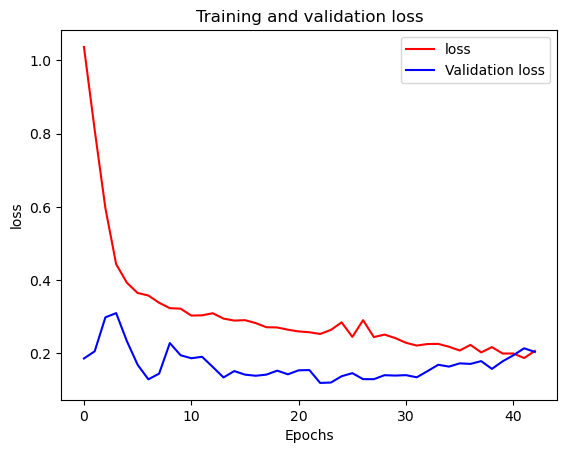

In [7]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = [*range(len(loss))]

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.title('Training and validation loss')
plt.xlabel("Epochs")
plt.ylabel("loss")
plt.legend(["loss", "Validation loss"])
plt.show()

#### Entrainement pour Lepen

In [8]:
model = createModel()
history = model.fit(X_trainNN, y_trainNN_Lepen,
                    epochs=1000,validation_data=(X_valNN, y_valNN_Lepen),
                    callbacks=[CallBackSave,callbackStop]
                   )

Epoch 1/1000
3/3 [==============================] - 0s 29ms/step - loss: 1.1129 - val_loss: 0.2851
Epoch 2/1000
3/3 [==============================] - 0s 6ms/step - loss: 0.9018 - val_loss: 0.3094
Epoch 3/1000
3/3 [==============================] - 0s 7ms/step - loss: 0.7706 - val_loss: 0.3565
Epoch 4/1000
3/3 [==============================] - 0s 7ms/step - loss: 0.6904 - val_loss: 0.3812
Epoch 5/1000
3/3 [==============================] - 0s 7ms/step - loss: 0.6541 - val_loss: 0.3640
Epoch 6/1000
3/3 [==============================] - 0s 7ms/step - loss: 0.6120 - val_loss: 0.3402
Epoch 7/1000
3/3 [==============================] - 0s 7ms/step - loss: 0.5966 - val_loss: 0.3299
Epoch 8/1000
3/3 [==============================] - 0s 7ms/step - loss: 0.5758 - val_loss: 0.3308
Epoch 9/1000
3/3 [==============================] - 0s 7ms/step - loss: 0.4758 - val_loss: 0.3644
Epoch 10/1000
3/3 [==============================] - 0s 7ms/step - loss: 0.5845 - val_loss: 0.3484
Epoch 11/1000
3/3 

In [10]:
best_model = tf.keras.models.load_model("best_model_valeur.h5")

print("Sur les entrainement la valeur reel : ", scalerLepen.inverse_transform(y_trainNN_Lepen[0].reshape(-1, 1)), "; valeur predite : ",scalerLepen.inverse_transform(best_model.predict(X_trainNN[0:1]).reshape(-1, 1)))

y_pred_NN = best_model.predict(X_testNN)

reel = scalerLepen.inverse_transform(y_testNN_Lepen)
prediction = scalerLepen.inverse_transform(y_pred_NN.reshape(-1, 1)).flatten()

print("Affichage des predictions sur le test pour Lepen")
affichagePrediction(prediction, reel)

test_loss = model.evaluate(X_testNN, y_testNN_Lepen)
print("Perte de test :", test_loss)

1/1 [==============================] - 0s 29ms/step
Sur les entrainement la valeur reel :  [[45.32699659]] ; valeur predite :  [[52.485577]]
1/1 [==============================] - 0s 10ms/step
Affichage des predictions sur le test pour Lepen
valeur prédite : 45.65823 valeur réelle : [48.1685974] écart : [2.51036757]
valeur prédite : 43.51064 valeur réelle : [44.14469083] écart : [0.63405164]
valeur prédite : 46.099983 valeur réelle : [50.99064795] écart : [4.89066473]
valeur prédite : 49.412235 valeur réelle : [41.40827309] écart : [8.00396217]
valeur prédite : 53.35951 valeur réelle : [51.96739645] écart : [1.39211206]
valeur prédite : 43.801426 valeur réelle : [57.04721893] écart : [13.245793]
valeur prédite : 49.54803 valeur réelle : [43.58210938] écart : [5.96592148]
valeur prédite : 49.645267 valeur réelle : [41.33164835] écart : [8.31361913]
valeur prédite : 52.982788 valeur réelle : [41.89070652] écart : [11.09208156]
valeur prédite : 45.98273 valeur réelle : [58.88169014] écart

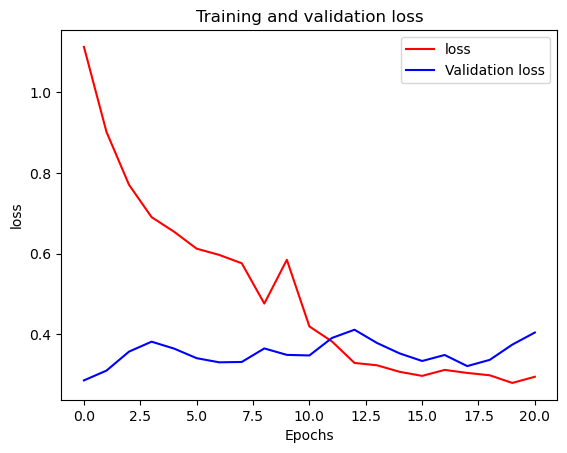

In [11]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = [*range(len(loss))]

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.title('Training and validation loss')
plt.xlabel("Epochs")
plt.ylabel("loss")
plt.legend(["loss", "Validation loss"])
plt.show()